- So now you have bounding box data for all train and test images.
- This script will rescale that data for the image size you'll use in pt_reg, then it will crop all the images to that size

In [1]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np
from glob import glob
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import math
import cv2
%matplotlib inline

#data_dir = os.path.join(os.getcwd(), 'data', 'whale')
#full_img_dir = os.path.join(os.getcwd(), 'data', 'whale', 'imgs')
cwd = os.getcwd()
output_dir = os.path.join(os.getcwd(), 'for_pt_reg')
input_dir  = os.path.join(os.getcwd(), 'imgs_subset')
#resize_dir = os.path.join(os.getcwd(), 'data', 'whale', 'resized')
#crop_dir = os.path.join(data_dir, 'crops')
TARGET_WIDTH = 300
TARGET_HEIGHT = 300
img_shape=(3, 224, 224)
target_size = (224,224)

Using Theano backend.


In [2]:
% cd $input_dir

/home/ryanryanadmin/Documents/ds/whale_recognition/imgs_subset


In [3]:
g = glob('*.jpg')

In [4]:
g[:5]

['w_281.jpg', 'w_224.jpg', 'w_116.jpg', 'w_99.jpg', 'w_0.jpg']

In [5]:
ann = pd.read_csv(os.path.join(cwd, 'bonnet_and_bbox.csv'))

In [6]:
subset = ann[ann.Image.isin(g)]

In [7]:
def find_new_points(r, target_width, target_height):
    #print(r)
    y_start = int(r.bboxy)
    x_start = int(r.bboxx)
    y_crop = int(r.bboxy + r.height)
    x_crop = int(r.bboxx + r.width) 
    
    x1_crop = r.x_1 - x_start
    x2_crop = r.x_2 - x_start
    x1_final = (target_width / r.width) * x1_crop
    x2_final = (target_width / r.width) * x2_crop


    y1_crop = r.y_1 - y_start
    y2_crop = r.y_2 - y_start
    y1_final = (target_height / r.height) * y1_crop
    y2_final = (target_height / r.height) * y2_crop
    
    return [r.Image, x1_final, x2_final, y1_final, y2_final]

In [13]:
t = subset.apply(lambda r: find_new_points(r, TARGET_WIDTH, TARGET_HEIGHT), axis=1)

In [14]:
t = np.array([np.array(l) for l in t.values])

In [15]:
t = pd.DataFrame(t, columns=['Image','x1_new', 'x2_new', 'y1_new', 'y2_new'])

In [16]:
subset = subset.merge(t, on ='Image', )

In [17]:
subset.head()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,y_1,x_2,y_2,x1_new,x2_new,y1_new,y2_new
0,w_446.jpg,whale_68116,479.229804,495.754970,3072,2048,1135.514954,797.929427,w_446.jpg,1241.459621,1110.779661,1396.642074,894.340977,64.42272554490101,158.3294711143255,196.42747078080296,60.93588687947836
1,w_133.jpg,whale_64006,539.739059,497.498611,3072,2048,1309.453890,718.087617,w_133.jpg,1649.834497,1149.575274,1545.698903,908.634098,205.52891359029752,142.73340562457207,239.87995711898773,105.95903407640415
2,w_112.jpg,whale_40169,412.073487,392.450940,3072,2048,1412.823384,840.966300,w_112.jpg,1584.494516,908.634098,1559.992024,988.267198,131.8594240976974,113.12906316137246,49.967372232564934,107.94229894606157
3,w_353.jpg,whale_28263,818.845565,762.258677,3072,2048,1145.052335,589.169370,w_353.jpg,1651.876371,1298.632104,1553.866401,922.927218,199.4899053289331,160.9163975123913,259.98752400920137,122.34073154999504
4,w_354.jpg,whale_34656,487.775239,385.004984,3072,2048,1852.932354,949.474443,w_354.jpg,2133.758724,1268.003988,1911.194417,1086.277168,219.54941002445176,46.124922407177316,196.19937372312864,84.4305886258863


In [18]:
len(subset)

223

In [19]:
% cd $cwd

/home/ryanryanadmin/Documents/ds/whale_recognition


In [20]:
subset.to_csv('subset_pt_data.csv', index=False)

In [49]:
def crop(r, target_width, target_height, input_dir, ouput_dir):
    r = r[1]
    path = os.path.join(input_dir, r.Image)
    im = cv2.imread(path)
    cropped = im[int(r.bboxy): int(r.bboxy + r.height), int(r.bboxx): int(r.bboxx+r.width)]
    sm  = cv2.resize(cropped, (target_width, target_height))
    cv2.imwrite(os.path.join(output_dir, r.Image), sm)

In [50]:
i = 0
for r in subset.iterrows():
    i+=1
    if i % 100 == 0: print(i)
    crop(r, TARGET_WIDTH, TARGET_HEIGHT, input_dir, output_dir)

100
200


In [53]:
def checkPts(r, target_width, target_height, input_dir):
    r = r[1]
    path = os.path.join(input_dir, r.Image)
    print(path)
    im = cv2.imread(path)
    fig, ax = plt.subplots()
    ax.imshow(im)
    ax.scatter(r.x1_new, r.y1_new, s=20, c='red', marker='o')
    ax.scatter(r.x2_new, r.y2_new, s=20, c='yellow', marker='o')

    #cv2.imwrite(os.path.join(save_dir, r.Image), rot_n)
    
    plt.show()

/home/ryanryanadmin/Documents/ds/whale_recognition/for_pt_reg/w_249.jpg


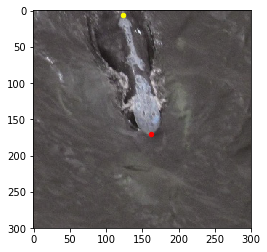

/home/ryanryanadmin/Documents/ds/whale_recognition/for_pt_reg/w_216.jpg


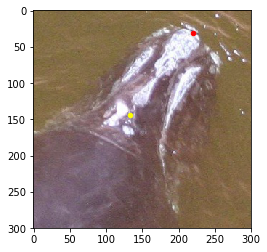

/home/ryanryanadmin/Documents/ds/whale_recognition/for_pt_reg/w_416.jpg


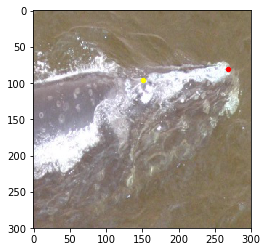

/home/ryanryanadmin/Documents/ds/whale_recognition/for_pt_reg/w_456.jpg


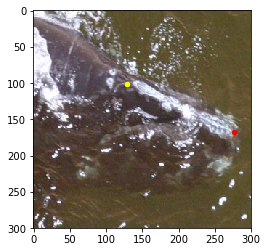

/home/ryanryanadmin/Documents/ds/whale_recognition/for_pt_reg/w_418.jpg


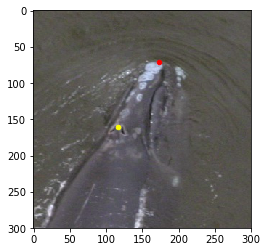

/home/ryanryanadmin/Documents/ds/whale_recognition/for_pt_reg/w_201.jpg


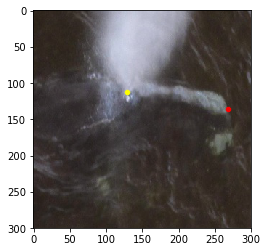

/home/ryanryanadmin/Documents/ds/whale_recognition/for_pt_reg/w_293.jpg


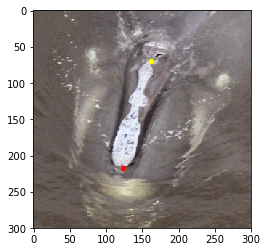

/home/ryanryanadmin/Documents/ds/whale_recognition/for_pt_reg/w_181.jpg


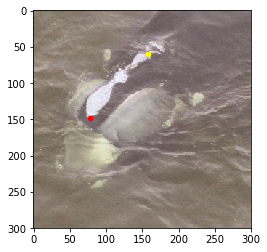

/home/ryanryanadmin/Documents/ds/whale_recognition/for_pt_reg/w_8.jpg


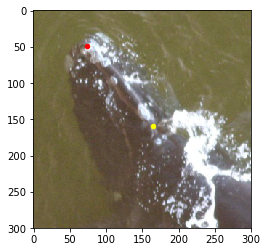

/home/ryanryanadmin/Documents/ds/whale_recognition/for_pt_reg/w_94.jpg


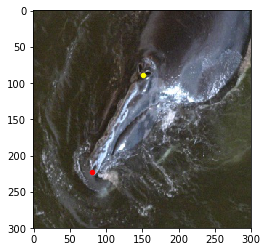

/home/ryanryanadmin/Documents/ds/whale_recognition/for_pt_reg/w_323.jpg


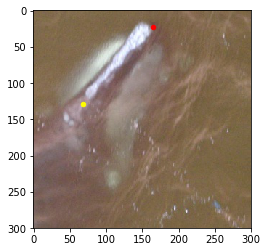

In [54]:
samp = subset.sample(frac=0.05)

for r in samp.iterrows():
    checkPts(r, TARGET_WIDTH, TARGET_HEIGHT, output_dir)